In [1]:
# 这部分是模板，用于 Jupyter lab 文件的初始导入和设置。
# 1. import built-in library
from datetime import datetime
import json
import os
import time

# 2. import 3rd party library
import cv2
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import pandas as pd
import PIL
from PIL import ImageOps
import tensorflow as tf
from tensorflow import keras

# 3. 导入自定义的函数
import deeplab_v3_plus
import plot_utils

from deeplab_v3_plus import MODEL_IMAGE_SIZE

# setup for the jupyter to show all results within one cell
InteractiveShell.ast_node_interactivity = "all"

# 如果有导入的外部 python 程序，对其进行实时更新。
%load_ext autoreload
%autoreload 2

# 控制显存.
config=tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True  # 设置动态分配 GPU 内存
sess=tf.compat.v1.Session(config=config)

# 使用混合精度 mixed precision进行训练，以提高训练速度。
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Compute dtype: float16
Variable dtype: float32


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 给出训练集图片 leftImg8bit_foggy\train 的路径。
train_images_dir = r'D:\deep_learning\computer_vision\segmentation\cityscapes\data\leftImg8bit_foggy\train'
train_images_list = deeplab_v3_plus.get_images_list(images_dir=train_images_dir)

# 给出训练集标签 gtFine\train 的路径。
train_labels_dir = r'D:\deep_learning\computer_vision\segmentation\cityscapes\data\gtFine\train'
# get_labels_list 中用到 labelIds。Cityscapes 场景分割只需要使用 labelIds 即可。
# labelIds 用于场景分割，而 instanceIds 则用于个体分割 instance segmentation。
# TrainIds 表示是用于特殊训练，会去掉一些类别。
train_labels_list = deeplab_v3_plus.get_labels_list(labels_dir=train_labels_dir)

In [4]:
# 给出验证集图片 leftImg8bit_foggy\val 的路径。
val_images_dir = r'D:\deep_learning\computer_vision\segmentation\cityscapes\data\leftImg8bit_foggy\val'
val_images_list = deeplab_v3_plus.get_images_list(images_dir=val_images_dir)

# 给出验证集标签 gtFine\val 的路径。
val_labels_dir = r'D:\deep_learning\computer_vision\segmentation\cityscapes\data\gtFine\val'
val_labels_list = deeplab_v3_plus.get_labels_list(labels_dir=val_labels_dir)

In [5]:
# 创建训练集和验证集 mask 的名字列表。
train_masks_list = deeplab_v3_plus.create_masks_list(train_images_list, train_labels_list)

val_masks_list = deeplab_v3_plus.create_masks_list(val_images_list, val_labels_list)

Creating the masks_list ...
1043/1500 [=================================>................] - ETA: 0s

In [6]:
f'MODEL_IMAGE_SIZE: {MODEL_IMAGE_SIZE}'
BATCH_SIZE = 8 
NUM_CLASSES = 34

'MODEL_IMAGE_SIZE: (512, 1024)'

In [7]:
train_dataset = deeplab_v3_plus.image_mask_dataset(train_images_list, train_masks_list, batch_size=BATCH_SIZE)
val_dataset = deeplab_v3_plus.image_mask_dataset(val_images_list, val_masks_list, batch_size=BATCH_SIZE)

print(f'Train dataset: {train_dataset}')
print(f'Val dataset: {val_dataset}')

Train dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(8, 512, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 1024, 1), dtype=tf.float32, name=None))>
Val dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(8, 512, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 1024, 1), dtype=tf.float32, name=None))>


In [8]:
# 设置自动保存模型的 checkpoint.

filename = 'cityscapes_deeplab_v3plus'
saved_file_path = f'accuracy_checkpoints/{filename}.h5'
checkpoint_callback = keras.callbacks.ModelCheckpoint(saved_file_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      verbose=0)

# Learning rate decay.
def scheduler(epoch, lr):
    """Step learning rate decay."""
    
    if epoch >= epochs_first_lr_decay and (epoch - epochs_first_lr_decay) % epochs_second_lr_decay == 0:
        # 在若干个迭代之后，对学习率进行阶跃衰减。建议同时打印信息，对用户进行提示。
        print(f'Changing the learning rate, \nbefore change: {lr:.2e}')
        lr *= rate_lr_decay
        print(f'after change: {lr:.2e}')   
    return lr
    
lr_decay_callback = keras.callbacks.LearningRateScheduler(scheduler)

callbacks_list = [checkpoint_callback, lr_decay_callback]

In [10]:
# 寻找超参时，使用 Pandas 记录数据。
records = pd.DataFrame({})
counter_records = 0

In [11]:
tic = time.time()

# 以下3个设置为学习率衰减设置，可以进行2次衰减。
epochs_first_lr_decay = 25  # 10
epochs_second_lr_decay = 65
rate_lr_decay = 0.1  # 0.5

# lr = 1e-4  # 0.001
learning_rates = [1e-4]
epochs = 30

count_down = len(learning_rates)
                
for lr in learning_rates:       
    
    # 仅在寻找 lr 等超参时需要使用 clear_session。每个不同的超参，使用一个新的 model。
    tf.keras.backend.clear_session()
    
    model = deeplab_v3_plus.inceptionresnetv2_deeplabv3plus(
        model_image_size=MODEL_IMAGE_SIZE, num_classes=NUM_CLASSES)
    
    # 在 Keras中，设置 from_logits=True 是方便的计算交叉熵的做法。
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)    
    optimizer_adam = keras.optimizers.Adam(learning_rate=lr)
    optimizer_mixed_precision = keras.mixed_precision.LossScaleOptimizer(optimizer_adam)

    model.compile(
        optimizer=optimizer_mixed_precision,
        loss=loss,
        # 根据损失函数的设置，这个 accuracy metrics会自动调用 metrics.SparseCategoricalAccuracy 
        metrics=['accuracy'])

    current_toc = time.time()
    current_duration = current_toc - tic
    current_minutes = current_duration / 60
    current_hours_spent = current_minutes / 60 

    print(f'count_down: {count_down}, lr: {lr}.')
    print(f'minutes_spent: {current_minutes:.0f}. hours_spent: {current_hours_spent:.1f}')
    count_down -= 1                

    history = model.fit(train_dataset, validation_data=val_dataset, 
                        epochs=epochs, callbacks=callbacks_list)  

    history_dict = history.history
    val_accuracy = history_dict['val_accuracy']
    accuracy = history_dict['accuracy']
    
    last_val_accuracy = round(val_accuracy[-1], 3)
    last_accuracy = round(accuracy[-1], 3)
    best_val_accuracy = round(max(val_accuracy), 3)
    
    over_fitting = round((accuracy[-1] - val_accuracy[-1]), 3)  
        
    records.loc[counter_records, 'last_val_accuracy'] = last_val_accuracy
    records.loc[counter_records, 'over_fitting'] = over_fitting
    records.loc[counter_records, 'last_accuracy'] = last_accuracy
    records.loc[counter_records, 'best_val_accuracy'] = best_val_accuracy
    
    records.loc[counter_records, 'lr'] = f'{lr:.2e}'
    records.loc[counter_records, 'epochs'] = epochs
    records.loc[counter_records, 'lr_decay_epoch'] = epochs_first_lr_decay

    counter_records += 1

toc = time.time()
duration = toc - tic
minutes = duration / 60
hours_spent = minutes / 60

count_down: 1, lr: 0.0001.
minutes_spent: 0. hours_spent: 0.0
Epoch 1/30
1115/1115 [==============================] - 1075s 931ms/step - loss: 1.0336 - accuracy: 0.8026 - val_loss: 0.6297 - val_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 2/30
1115/1115 [==============================] - 1043s 935ms/step - loss: 0.4991 - accuracy: 0.8810 - val_loss: 0.4779 - val_accuracy: 0.8703 - lr: 1.0000e-04
Epoch 3/30
1115/1115 [==============================] - 1016s 911ms/step - loss: 0.3791 - accuracy: 0.9003 - val_loss: 0.4163 - val_accuracy: 0.8817 - lr: 1.0000e-04
Epoch 4/30
1115/1115 [==============================] - 1016s 911ms/step - loss: 0.3116 - accuracy: 0.9141 - val_loss: 0.4845 - val_accuracy: 0.8721 - lr: 1.0000e-04
Epoch 5/30
1115/1115 [==============================] - 1006s 902ms/step - loss: 0.2662 - accuracy: 0.9248 - val_loss: 0.3904 - val_accuracy: 0.8917 - lr: 1.0000e-04
Epoch 6/30
1115/1115 [==============================] - 1017s 912ms/step - loss: 0.2303 - accuracy: 0.9338 -

In [12]:
f'Time spent: {hours_spent:.1f} hours'
records.sort_values(by='last_val_accuracy', ascending=False)

'Time spent: 8.6 hours'

last_val_accuracy  over_fitting  last_accuracy  best_val_accuracy  \
0              0.912         0.065          0.977              0.912   

         lr  epochs  lr_decay_epoch  
0  1.00e-04    30.0            25.0

In [14]:
# 画出准确度和loss的折线图。

history_dict = history.history
# loss_drop = history_dict['loss'][0] - history_dict['loss'][-1]
# val_loss_drop = history_dict['val_loss'][0] - history_dict['val_loss'][-1]
# loss_overfitting = history_dict['val_loss'][-1] - history_dict['loss'][-1]

current_time = datetime.now()
title = (f'{filename}, epochs: {epochs}, <br />'
         f'last validation accuracy: {last_val_accuracy}, last accuracy: {last_accuracy}, '
         f'best_val_accuracy: {best_val_accuracy}, accuracy overfitting: {over_fitting}<br />'
         f'duration: {minutes:.1f} minutes, {hours_spent:.1f} hours. {current_time:%Y-%m-%d, %H:%m}')

plot_utils.scatter_plotly_keras(history_dict, title, filename, plot_loss=False)

In [15]:
# keras.utils.plot_model(model, to_file='deeplab_v3_plus_inception_resnetv2.png', show_shapes=True, dpi=900)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0960943 to fit



In [44]:
# 可以调用已保存的模型。
# saved_model = keras.models.load_model(saved_file_path)
# # saved_model.evaluate(train_dataset)
# print(f'Saved model on validation set:')
# saved_model.evaluate(val_dataset)

In [17]:
# 导入 colormap，显示最终的 segmentation 效果。

colormap_name = 'colormap_cityscapes.json'

# colormap_cityscapes.json 文件中有 35 个类别，其中有一个类别是车牌，可能是 Cityscapes 的保留
# 类别，可以去掉，于是总共有 34 个类别用于做 segmentation 分类。

try:
    with open(colormap_name, 'r') as f:
        colormap_cityscapes = json.load(f)
        type(colormap_cityscapes)
        len(colormap_cityscapes)
except FileNotFoundError:
    print('Not found file.')

# 如果要查看中的颜色和类别对应关系，可以用下面这 2行。
# for each in colormap_cityscapes:
#     print(f'{each[1]}\t{each[2]}\t\t{each[0]}')
    
colormap = np.zeros(shape=(NUM_CLASSES, 3))
for i, each in enumerate(colormap_cityscapes[: -1]):
    colormap[i] = each[-1]

colormap = colormap.astype(np.uint8)
colormap.shape
# 用 30 种颜色代表 34 种分类，注意对每一个类别，都有 RGB 3个值。前 5 种都用黑色表示。
colormap

list

35

(34, 3)

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [111,  74,   0],
       [ 81,   0,  81],
       [128,  64, 128],
       [244,  35, 232],
       [250, 170, 160],
       [230, 150, 140],
       [ 70,  70,  70],
       [102, 102, 156],
       [190, 153, 153],
       [180, 165, 180],
       [150, 100, 100],
       [150, 120,  90],
       [153, 153, 153],
       [153, 153, 153],
       [250, 170,  30],
       [220, 220,   0],
       [107, 142,  35],
       [152, 251, 152],
       [ 70, 130, 180],
       [220,  20,  60],
       [255,   0,   0],
       [  0,   0, 142],
       [  0,   0,  70],
       [  0,  60, 100],
       [  0,   0,  90],
       [  0,   0, 110],
       [  0,  80, 100],
       [  0,   0, 230],
       [119,  11,  32]], dtype=uint8)

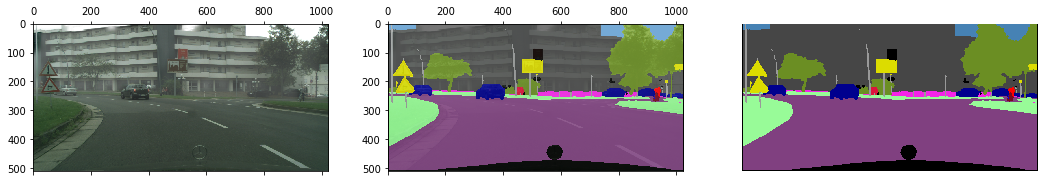

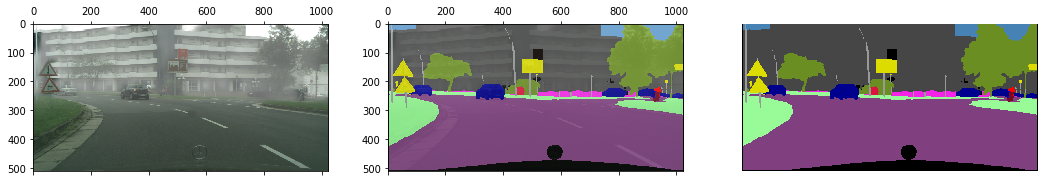

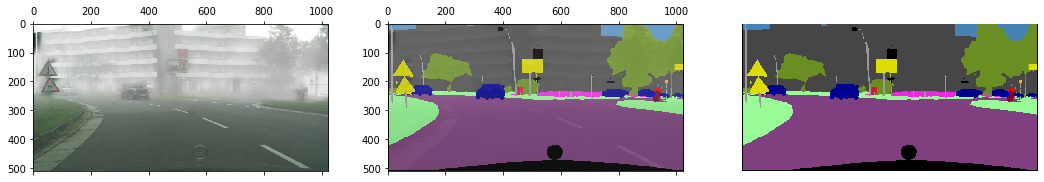

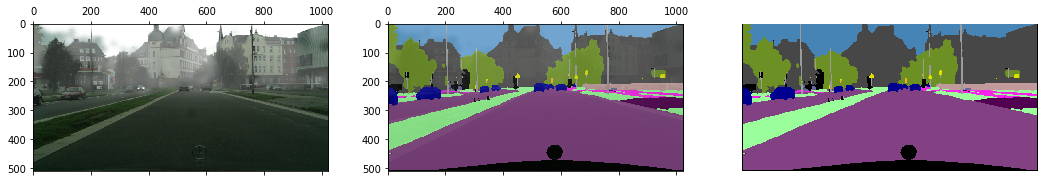

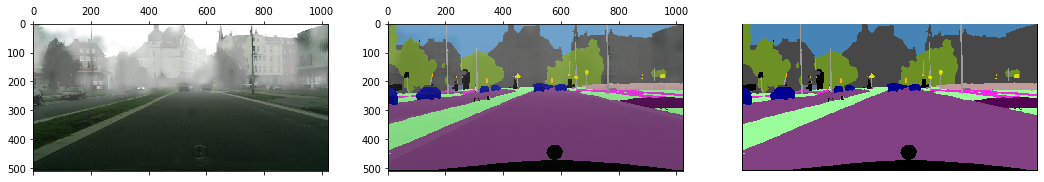

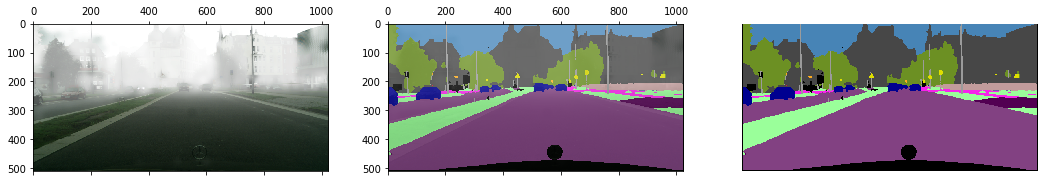

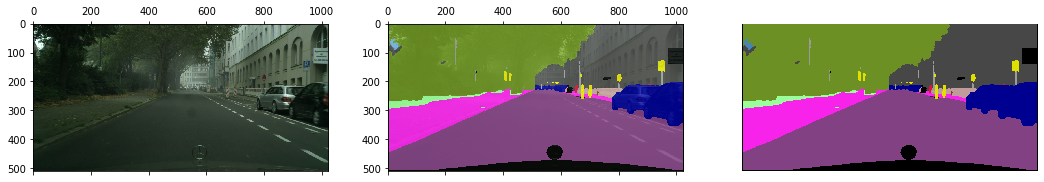

In [18]:
# Train 数据集上的结果。 train_images 是一个文件名列表。
images_to_check = 7
deeplab_v3_plus.plot_predictions(
    train_images_list[: images_to_check], colormap, model=model, num_classes=NUM_CLASSES)

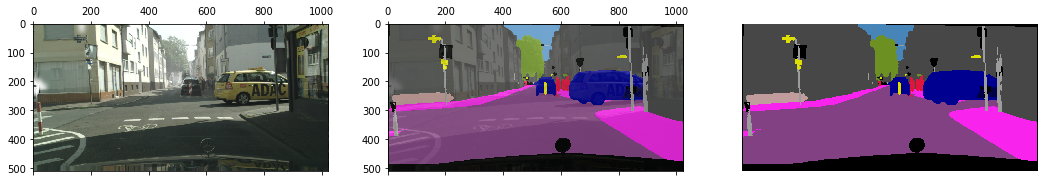

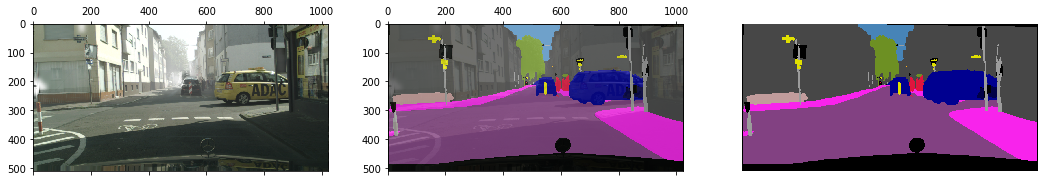

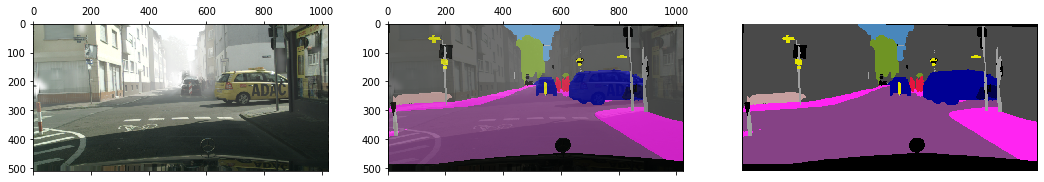

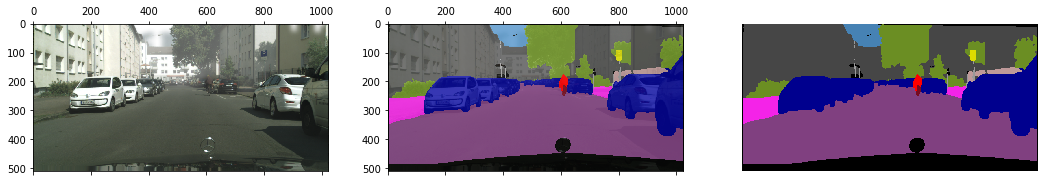

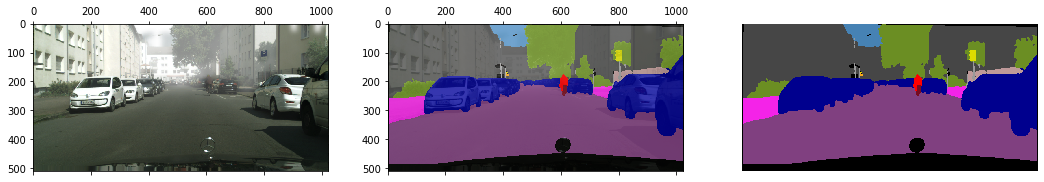

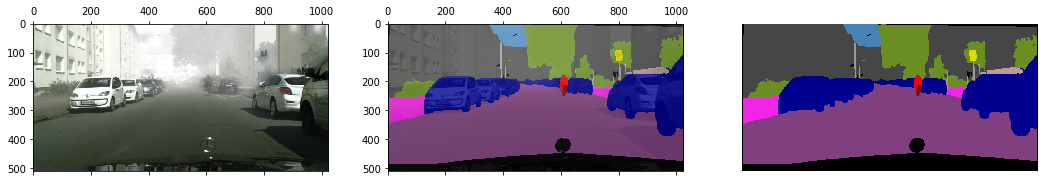

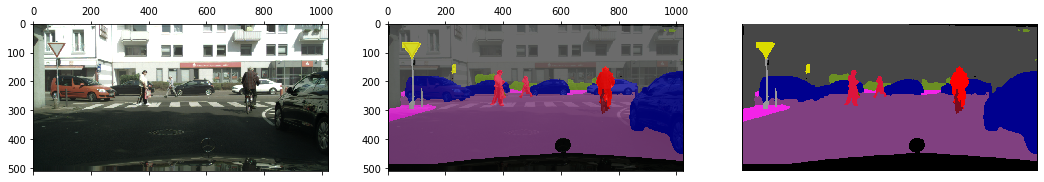

In [19]:
# validation 数据集上的结果。
deeplab_v3_plus.plot_predictions(
    val_images_list[: images_to_check], colormap, model=model, num_classes=NUM_CLASSES)

In [20]:
stop here
上面的训练完成之后，如果对验证集结果基本满意，再查看下面测试集的情况。

SyntaxError: invalid syntax (318882083.py, line 1)

In [21]:
# 给出测试集图片 leftImg8bit_foggy\test 的路径。
test_images_dir = r'D:\deep_learning\computer_vision\segmentation\cityscapes\data\leftImg8bit_foggy\test'
test_images_list = deeplab_v3_plus.get_images_list(images_dir=test_images_dir)

# 给出测试集标签 gtFine\test 的路径。
test_labels_dir = r'D:\deep_learning\computer_vision\segmentation\cityscapes\data\gtFine\test'
test_labels_list = deeplab_v3_plus.get_labels_list(labels_dir=test_labels_dir)

# 创建测试集 mask 的名字列表。
test_masks_list = deeplab_v3_plus.create_masks_list(test_images_list, test_labels_list)

Creating the masks_list ...
4419/4575 [===============================================>..] - ETA: 0s

In [26]:
test_dataset = deeplab_v3_plus.image_mask_dataset(test_images_list, test_masks_list, batch_size=BATCH_SIZE)
print(f'Test dataset: {test_dataset}')

Test dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(8, 512, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 1024, 1), dtype=tf.float32, name=None))>


In [27]:
# 最终测试集准确度为 84.2%
model.evaluate(test_dataset)

571/571 [==============================] - 93s 162ms/step - loss: 1.6221 - accuracy: 0.8420


[1.6221370697021484, 0.8420333862304688]

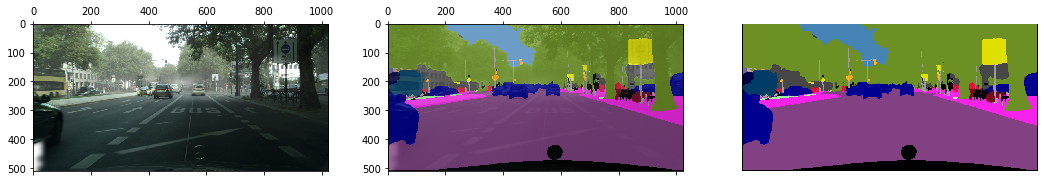

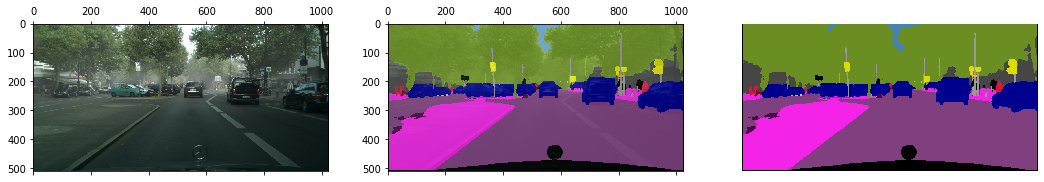

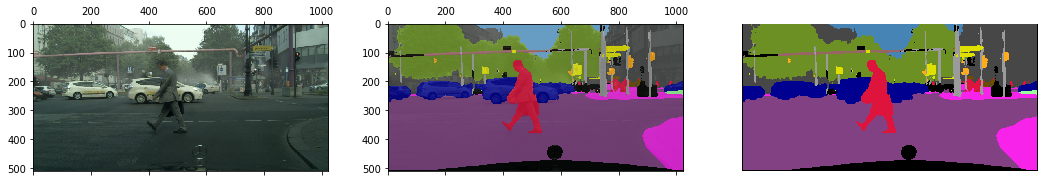

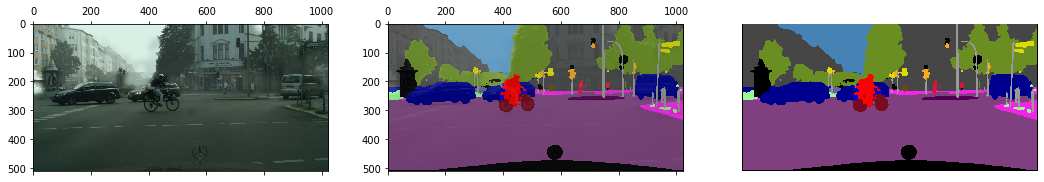

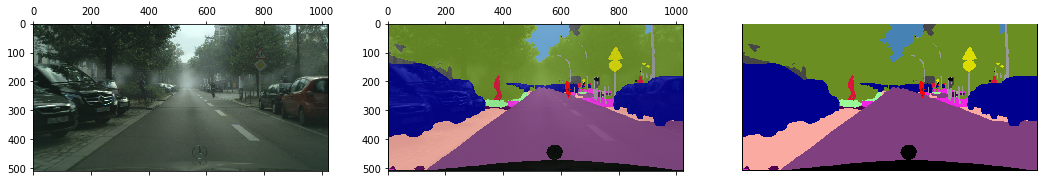

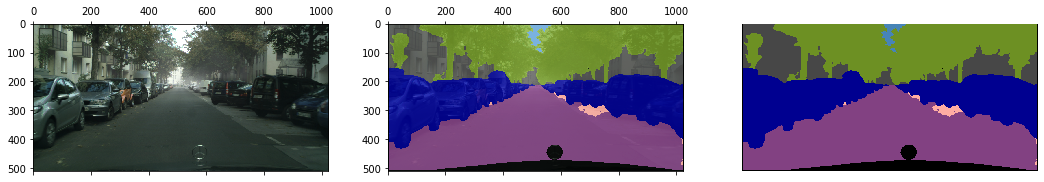

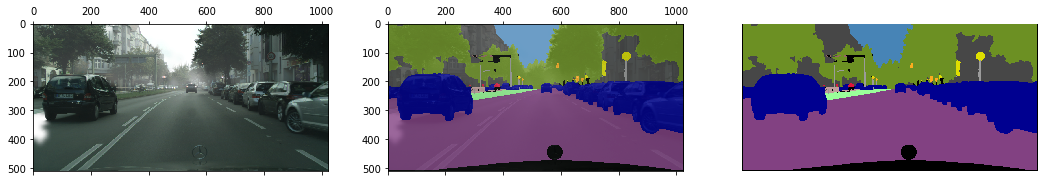

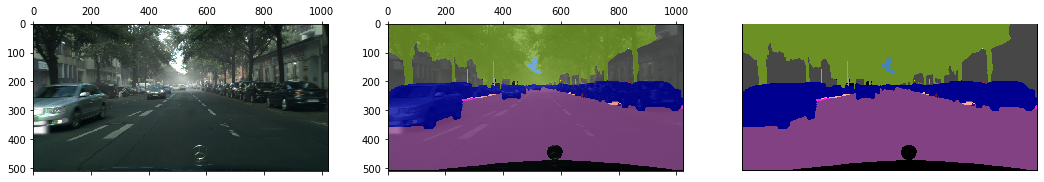

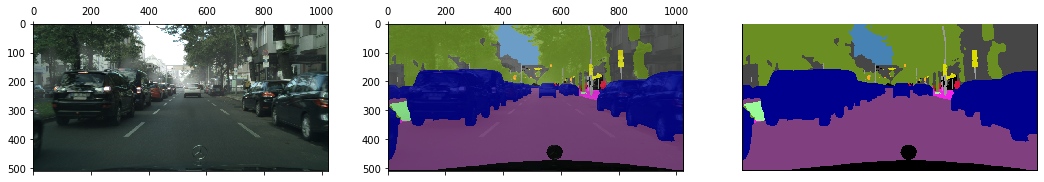

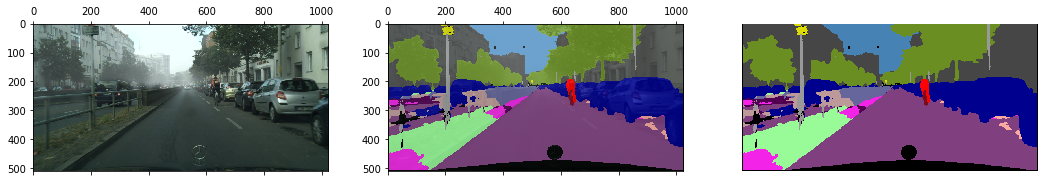

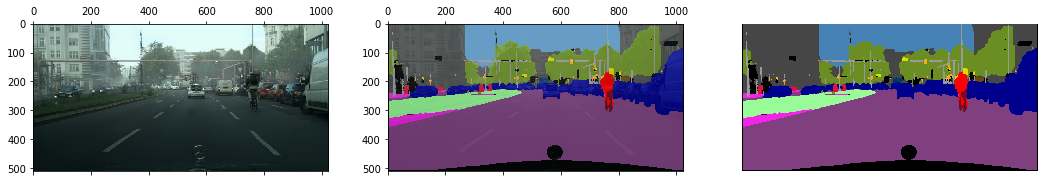

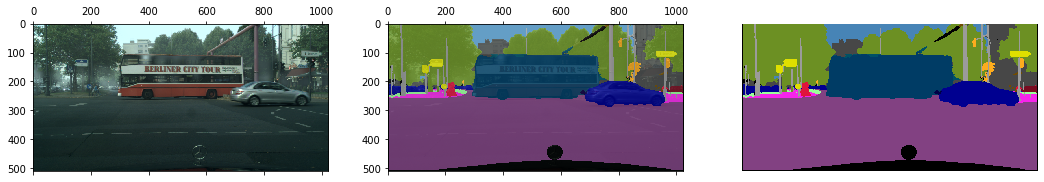

In [28]:
# 测试集上的结果。 
test_images_to_check = 12 * 3
deeplab_v3_plus.plot_predictions(
    test_images_list[0: 0 + test_images_to_check: 3], colormap, model=model, num_classes=NUM_CLASSES)

In [29]:
# 一个奇怪的事情是，test 数据集的 label 看上去质量很差，如下图。还不如模型预测出来的效果好看。
# one_mask = keras.preprocessing.image.load_img(test_masks_list[0]) 
# PIL.ImageOps.autocontrast(one_mask)